In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import wandb
from sklearn.feature_extraction import FeatureHasher
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [2]:
data_path = "SoftwareEngineer_cleaned.csv"
data= pd.read_csv(data_path)
print(data.shape)
data.head()

(34012, 12)


,title,level,company,yearsofexperience,totalyearlycompensation,gender,Doctorate_Degree,Masters_Degree,Bachelors_Degree,tag,state,city
0,Software Engineer,SE 2,eBay,5.0,100000,NaN,0,0,0,NaN,CA,San Francisco
1,Software Engineer,60,Microsoft,5.0,157000,NaN,0,0,0,NaN,CA,Mountain View
2,Software Engineer,63,Microsoft,8.5,208000,NaN,0,0,0,NaN,WA,Seattle
3,Software Engineer,62,Microsoft,4.0,156000,NaN,0,0,0,NaN,WA,Seattle
4,Software Engineer,59,Microsoft,3.0,120000,NaN,0,0,0,NaN,WA,Redmond


In [3]:
headers = ["company", "yearsofexperience", "Doctorate_Degree", "Masters_Degree", "Bachelors_Degree", "state", "city", "tag", "gender", 'level',"totalyearlycompensation"]
data_clean = data[headers]
data_clean

,company,yearsofexperience,Doctorate_Degree,Masters_Degree,Bachelors_Degree,state,city,tag,gender,level,totalyearlycompensation
0,eBay,5.0,0,0,0,CA,San Francisco,NaN,NaN,SE 2,100000
1,Microsoft,5.0,0,0,0,CA,Mountain View,NaN,NaN,60,157000
2,Microsoft,8.5,0,0,0,WA,Seattle,NaN,NaN,63,208000
3,Microsoft,4.0,0,0,0,WA,Seattle,NaN,NaN,62,156000
4,Microsoft,3.0,0,0,0,WA,Redmond,NaN,NaN,59,120000
...,...,...,...,...,...,...,...,...,...,...,...
34007,Google,10.0,0,0,0,WA,Seattle,Distributed Systems (Back-End),NaN,T4,327000
34008,Microsoft,2.0,0,0,0,WA,Redmond,Full Stack,NaN,62,237000
34009,MSFT,14.0,0,0,0,WA,Seattle,Full Stack,NaN,63,220000
34010,Salesforce,8.0,0,0,0,CA,San Francisco,iOS,NaN,Lead MTS,280000


In [4]:
# Get the summary of the DataFrame
summary = data_clean.describe()

# Print the summary
summary

,yearsofexperience,Doctorate_Degree,Masters_Degree,Bachelors_Degree,totalyearlycompensation
count,34012.000000,34012.000000,34012.000000,34012.000000,34012.000000
mean,6.003482,0.023139,0.225714,0.180877,224651.105669
std,5.167421,0.150347,0.418058,0.384922,113622.826878
min,0.000000,0.000000,0.000000,0.000000,35000.000000
25%,2.000000,0.000000,0.000000,0.000000,151000.000000
50%,5.000000,0.000000,0.000000,0.000000,196000.000000
75%,9.000000,0.000000,0.000000,0.000000,268000.000000
max,29.000000,1.000000,1.000000,1.000000,999000.000000


C:\Users\pedia\AppData\Local\Temp\ipykernel_20388\2527841507.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<AxesSubplot:>

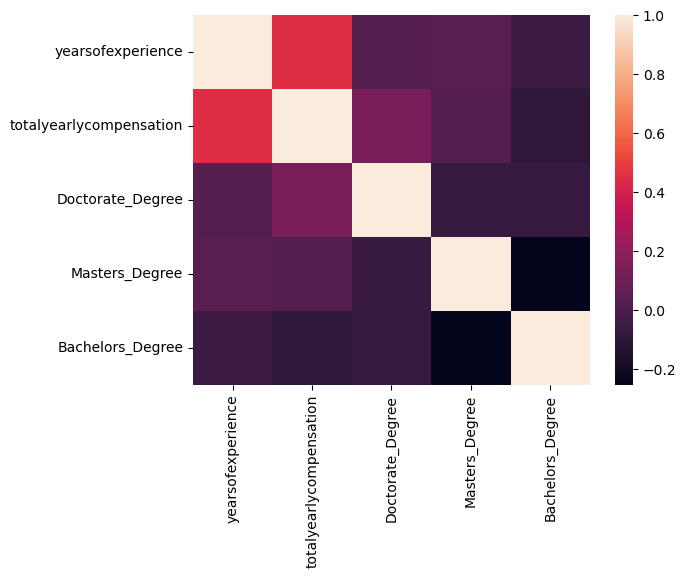

In [5]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [6]:
from scipy.stats import pearsonr
corr, _ = pearsonr(data['totalyearlycompensation'], data['yearsofexperience'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.449


# Define categorical variables
categorical_vars = ["company", "state", "city", "tag", "gender", 'level']

# Create a hash-based encoder object with n_features 
encoder = FeatureHasher(n_features=1000, input_type='string')

# Encode categorical variables using the hash-based encoder
encoded_data = pd.DataFrame(encoder.transform(data[categorical_vars]).toarray())

# Add the encoded variable names to the dataframe
encoded_data.columns = ["encoded_" + str(i) for i in range(encoded_data.shape[1])]

# Combine the encoded data with the original dataframe
data_encoded = pd.concat([data.drop(columns=categorical_vars), encoded_data], axis=1)
data_encoded.head()

data_clean = data_clean.merge(encoded_data,left_index=True, right_index=True)
data_clean = data_clean.drop(categorical_vars,1)
data_clean           # Merge one-hot encoded features and drop the originals

In [7]:
encoder = OneHotEncoder(sparse_output=False)
categorical_vars = ["company", "state", "city", "tag", "gender", 'level']
encode_data = pd.DataFrame(encoder.fit_transform(data[categorical_vars]), index=data_clean.index)
# Add the encoded variable names to the dataframe
encode_data.columns = encoder.get_feature_names_out(categorical_vars)
encode_data.head()

,company_10x Genomics,company_23andMe,company_2U,company_3M,company_3m,company_7-Eleven,company_7-eleven,company_8x8,company_ABB,company_ADP,...,level_unknown,level_vice president,level_x2,level_x4,level_x5,level_x6,level_x7,level_z4,level_||,level_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data_clean = data_clean.merge(encode_data,left_index=True, right_index=True)
data_clean = data_clean.drop(categorical_vars,1)
data_clean           # Merge one-hot encoded features and drop the originals

C:\Users\pedia\AppData\Local\Temp\ipykernel_20388\2642179865.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_clean = data_clean.drop(categorical_vars,1)


,yearsofexperience,Doctorate_Degree,Masters_Degree,Bachelors_Degree,totalyearlycompensation,company_10x Genomics,company_23andMe,company_2U,company_3M,company_3m,...,level_unknown,level_vice president,level_x2,level_x4,level_x5,level_x6,level_x7,level_z4,level_||,level_nan
0,5.0,0,0,0,100000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0,0,0,157000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.5,0,0,0,208000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0,0,0,156000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0,0,0,120000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34007,10.0,0,0,0,327000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34008,2.0,0,0,0,237000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34009,14.0,0,0,0,220000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34010,8.0,0,0,0,280000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X = data_clean.drop(columns=["totalyearlycompensation"]).values
Y = data_clean.totalyearlycompensation.values.reshape(-1, 1)

In [10]:
X

array([[ 5. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 5. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 8.5,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ...,
       [14. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 8. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]])

In [11]:
Y

array([[100000],
       [157000],
       [208000],
       ...,
       [220000],
       [280000],
       [200000]], dtype=int64)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [13]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
print(X_train_scaled.shape)
print(X_train_scaled)
X_test_scaled = MinMaxScaler().fit_transform(X_test)
print(X_test_scaled)
print(X_test_scaled)

(27209, 4215)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.68965517 0.         0.         ... 0.         0.         0.        ]
 [0.10344828 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.13793103 0.         1.         ... 0.         0.         0.        ]
 [0.13793103 0.         0.         ... 0.         0.         0.        ]
 [0.03448276 0.         0.         ... 0.         0.         0.        ]]
[[0.10344828 0.         1.         ... 0.         0.         0.        ]
 [0.24137931 0.         0.         ... 0.         0.         0.        ]
 [0.06896552 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.20689655 0.         1.         ... 0.         0.         0.        ]
 [0.06896552 0.         1.         ... 0.         0.         0.        ]
 [0.17241379 0.         1.         ... 0.         0.         0.        ]]
[[0.10344828 0.         1.         ... 0.         0.         0.        ]
 [0.24137931 0.         0

In [14]:
X_train_tensor = torch.from_numpy(X_train_scaled).float()
print(X_train_tensor.shape)
print(X_train_tensor)

torch.Size([27209, 4215])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6897, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1034, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1379, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1379, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0345, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [15]:
#X_train_tensor = X_train_tensor.float()
torch.isnan(X_train_tensor)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [16]:
X_test_tensor = torch.from_numpy(X_test_scaled).float()
print(X_test_tensor.shape)
print(X_test_tensor)

torch.Size([6803, 4215])
tensor([[0.1034, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2414, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0690, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2069, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0690, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1724, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [17]:
y_train_tensor =torch.from_numpy(y_train).float()
print(y_train_tensor.shape)
print(y_train_tensor)

torch.Size([27209, 1])
tensor([[220000.],
        [377000.],
        [145000.],
        ...,
        [192000.],
        [262000.],
        [ 75000.]])


In [18]:
y_test_tensor = torch.from_numpy(y_test).float()
print(y_test_tensor.shape)
print(y_test_tensor)

torch.Size([6803, 1])
tensor([[195000.],
        [313000.],
        [150000.],
        ...,
        [140000.],
        [138000.],
        [197000.]])


In [19]:
# check the shapes of input and target variables
print("Shape of X_train:", X_train_tensor.shape)
print("Shape of y_train:", y_train_tensor.shape)
print("Shape of X_test:", X_test_tensor.shape)
print("Shape of y_test:", y_test_tensor.shape)


Shape of X_train: torch.Size([27209, 4215])
Shape of y_train: torch.Size([27209, 1])
Shape of X_test: torch.Size([6803, 4215])
Shape of y_test: torch.Size([6803, 1])


In [20]:
batch_size = 264
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [21]:
number_input_features = len(X_train_tensor[0])
hidden_nodes_layer1 = 4500
hidden_nodes_layer2 = 3000
hidden_nodes_layer3 = 1000
hidden_nodes_layer4 = 300

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(number_input_features, hidden_nodes_layer1, bias=False)
        self.fc2 = nn.Linear(hidden_nodes_layer1, hidden_nodes_layer2, bias=False)
        self.fc3 = nn.Linear(hidden_nodes_layer2, hidden_nodes_layer3, bias=False)
        self.fc4 = nn.Linear(hidden_nodes_layer3, hidden_nodes_layer4, bias=False)
        self.fc5 = nn.Linear(hidden_nodes_layer4, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the model and print the model structure
model = Net()
print(model)

# Define the loss function, optimizer and the metric
criterion = torch.nn.SmoothL1Loss()
#optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999),weight_decay=0, amsgrad=False)
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.01)
metric = nn.SmoothL1Loss()




Net(
  (fc1): Linear(in_features=4215, out_features=4500, bias=False)
  (fc2): Linear(in_features=4500, out_features=3000, bias=False)
  (fc3): Linear(in_features=3000, out_features=1000, bias=False)
  (fc4): Linear(in_features=1000, out_features=300, bias=False)
  (fc5): Linear(in_features=300, out_features=1, bias=False)
)


In [22]:
wandb.init(project="Regression-MLP")



# Number of epochs
num_epochs = 10

# Lists to store the training loss and accuracy for each epoch
train_loss = []
train_acc = []
# Regularization hyperparameter
#lambda_ = 0.1

# Training loop
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)
        # Compute the loss
        loss = criterion(y_pred, y_batch)
        # reg = 0
        #  for param in model.parameters():
        #     reg += param.norm(2)
        #Add regularization term to the loss
        #loss += lambda_ * reg
        # Compute the R2 score
        r2 = r2_score(y_batch.detach().numpy(), y_pred.detach().numpy())
        # Compute the MAPE
        mape = mean_absolute_percentage_error(y_batch.detach().numpy(), y_pred.detach().numpy())
        # Zero the gradients
        optimizer.zero_grad()
        # Perform the backward pass
        loss.backward()
        # Update the parameters
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss {loss.item()}, R2 {r2}, MAPE {mape}')
    

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            y_test_pred = model(X_test_batch)
            test_loss = criterion(y_test_pred, y_test_batch)
            test_r2 = r2_score(y_test_batch.detach().numpy(), y_test_pred.detach().numpy())
            test_mape = mean_absolute_percentage_error(y_test_batch.detach().numpy(), y_test_pred.detach().numpy())
    print(f"Epoch {epoch+1}, Test Loss {test_loss}, Test R2 {test_r2}, Test MAPE {test_mape}")
    # Log the training and test metrics
    wandb.log({"train_loss": loss.item(), "train_r2": r2, "train_mape": mape, 
               "test_loss": test_loss, "test_r2": test_r2, "test_mape": test_mape})
    

wandb: Currently logged in as: pedi4tor (aicyber). Use `wandb login --relogin` to force relogin


Epoch 1, Loss 34677.62109375, R2 0.5167441393565007, MAPE 0.22288191318511963
Epoch 1, Test Loss 59455.05859375, Test R2 0.09513897692504525, Test MAPE 0.2323407679796219
Epoch 2, Loss 22884.27734375, R2 0.8133484311534632, MAPE 0.12410100549459457
Epoch 2, Test Loss 48277.921875, Test R2 0.5226089201483994, Test MAPE 0.17769743502140045
Epoch 3, Loss 27920.42578125, R2 0.6125729205605364, MAPE 0.1350184977054596
Epoch 3, Test Loss 48423.04296875, Test R2 0.5632713902932858, Test MAPE 0.18322588503360748
Epoch 4, Loss 21681.984375, R2 0.8866054472548939, MAPE 0.10480162501335144
Epoch 4, Test Loss 38395.71484375, Test R2 0.6741062258225087, Test MAPE 0.16457483172416687
Epoch 5, Loss 30596.69921875, R2 0.9030024903187285, MAPE 0.15769897401332855
Epoch 5, Test Loss 38707.1484375, Test R2 0.7270642796750925, Test MAPE 0.15331347286701202
Epoch 6, Loss 32840.63671875, R2 0.8032634268042701, MAPE 0.17205126583576202
Epoch 6, Test Loss 39370.3125, Test R2 0.673429955237153, Test MAPE 0.183

In [23]:
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.show()
    plt.close()

          Predicted    Actual
0     246057.640625  332000.0
1     234390.234375  180000.0
2     400077.000000  450000.0
3     294325.406250  345000.0
4     225175.093750  218000.0
...             ...       ...
6798  218757.718750  215000.0
6799  189621.125000  222000.0
6800  169604.281250  165000.0
6801  100240.164062  103000.0
6802  516310.468750  300000.0

[6803 rows x 2 columns]


C:\Users\pedia\AppData\Local\Temp\ipykernel_20388\2281681281.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
C:\Users\pedia\AppData\Local\Temp\ipykernel_20388\2281681281.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = 

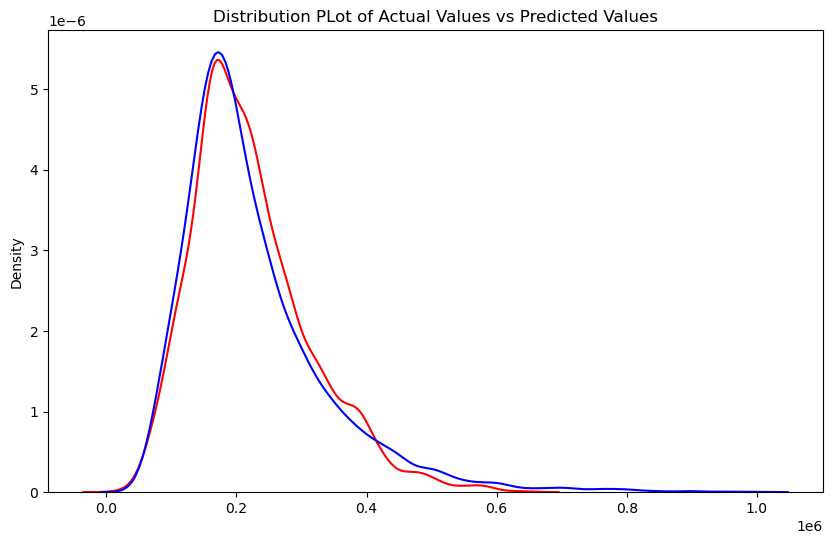

In [24]:
# Create lists to store the predicted and actual values
y_test_pred_list = []
y_test_list = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        y_test_pred = model(X_test_batch)
        y_test_pred_list.extend(y_test_pred.detach().numpy().flatten().tolist())
        y_test_list.extend(y_test_batch.detach().numpy().flatten().tolist())

# Create a dataframe to show the predicted and actual values
df_pred_actual = pd.DataFrame({'Predicted': y_test_pred_list, 'Actual': y_test_list})
print(df_pred_actual)
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(y_test_pred_list, y_test_list, 'Actual Values(test data)', 'Predicted Values(test data)', Title)